In [2]:
from transformers import ViTFeatureExtractor, ViTModel
import torch
from PIL import Image
import requests
import os
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Load a pretrained ViT model
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\t_om\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\t_om\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
from transformers import BartTokenizer, BartForConditionalGeneration, ViTImageProcessor, BartConfig
import torch.nn as nn
import os
from datasets import load_dataset
from torch.utils.data import DataLoader
import random

vit_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

customBartConfig = BartConfig(
    d_model=256,
    encoder_layers=2,
    decoder_layers=2,          
    encoder_attention_heads=4,  #
    decoder_attention_heads=4,
    encoder_ffn_dim=1024,       
    decoder_ffn_dim=1024,
    max_position_embeddings=256,
    vocab_size=50265,          
    pad_token_id=1,
    bos_token_id=0,
    eos_token_id=2
)

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base") #still use tokenizer of BART base  
bartModel = BartForConditionalGeneration(customBartConfig)  

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print(torch.cuda.get_device_name(0))

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

pixelValueShapes = set()

projector = nn.Sequential(nn.Linear(768, customBartConfig.d_model), nn.LayerNorm(customBartConfig.d_model), nn.Dropout(0.1))

def tokenize_caption(batch):
    return tokenizer(
        batch["answer"],
        padding="max_length",
        truncation=True,
        max_length=64,
        return_tensors="pt"
    )
  

def select_random_caption(row):
   row['answer'] = random.choice(row['answer'])
   
   return row

def convert_to_pixel_values(row):

   try:
     converted_rgb_image = row['image'].convert('RGB')
     del row['image']
     row['pixel_values'] = vit_processor(images=converted_rgb_image, return_tensors="pt", do_resize=True,
        size={"height": 224, "width": 224})['pixel_values'].squeeze(0)

     if row['pixel_values'].shape not in pixelValueShapes:
          pixelValueShapes.add(row['pixel_values'].shape)
          print(f"Pixel value dimensions: {row['pixel_values'].shape}")
          
   except Exception as e:
     print(f"Failure in trying to convert row {e}")
   
   return row

cuda
NVIDIA GeForce GTX 1650


In [3]:
#load training set
train_set = load_dataset("lmms-lab/COCO-Caption", split="val[:7500]")
print(train_set.column_names)
train_set = train_set.map(select_random_caption)
train_set = train_set.map(convert_to_pixel_values)
 
train_set.set_format(type="torch", columns=["pixel_values", "answer"])

train_loader = DataLoader(dataset=train_set, batch_size=4, shuffle=True, num_workers=4)


Generating test split: 100%|██████████| 40775/40775 [01:53<00:00, 360.06 examples/s]


['question_id', 'image', 'question', 'answer', 'id', 'license', 'file_name', 'coco_url', 'height', 'width', 'date_captured']


Map:   0%|          | 14/7500 [00:00<03:36, 34.61 examples/s]

Pixel value dimensions: torch.Size([3, 224, 224])


Map: 100%|██████████| 7500/7500 [03:05<00:00, 40.54 examples/s] 


In [ ]:
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup


optimizer = torch.optim.AdamW(
    list(bartModel.parameters()) + list(vit_model.parameters()) + list(projector.parameters()), lr=3e-4, weight_decay=0.01
)


projector.to(device) 
no_of_accumulation_steps = 16

def train_multimodal_model(num_epochs=30):
    bartModel.to(device)
    vit_model.to(device)
    epochs = []
    average_losses = []
    
    num_of_training_steps = (num_epochs * len(train_loader))//no_of_accumulation_steps
    num_of_warmup_steps = num_of_training_steps//5
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_of_warmup_steps, num_training_steps=num_of_training_steps) #leveraged to vary the learning rate as the training progresses

    for epoch in range(num_epochs):
        loss_total = 0
        bartModel.train()
        vit_model.train()
        projector.train()
        num_steps = 0
        total_num_real_tokens = 0

        for batch in train_loader:
            tokenizedBatch = tokenize_caption(batch)
            
            tokenizedBatch['pixel_values'] = batch['pixel_values'] #the tokenizer function does not preserve image values
            
                
            batchOnGPU = {key: value.to(device) for key, value in tokenizedBatch.items()} #move to device

            encoder_latent_output = vit_model(pixel_values=batchOnGPU['pixel_values']).last_hidden_state
            encoder_mask = torch.ones(encoder_latent_output.size()[:-1], dtype=torch.long, device=encoder_latent_output.device) 
            bart_encoder_output = bartModel.model.encoder(inputs_embeds=projector(encoder_latent_output), attention_mask=encoder_mask)
            labels = batchOnGPU['input_ids'].clone()
            labels[labels == tokenizer.pad_token_id] = -100
 
            outputs = bartModel(
                encoder_outputs=bart_encoder_output,
                labels=labels,
                attention_mask=encoder_mask #encoder attention mask allows the decoder to be aware that all eoncder outputp positions are valid (1)
            )

            num_real_tokens = (labels != -100).sum().item()
            loss = outputs.loss/no_of_accumulation_steps #scale the tensor to prevent the accumulation of extremely large gradients
            loss_total += (outputs.loss.item() * num_real_tokens)
            total_num_real_tokens+=num_real_tokens

            loss.backward()

            num_steps+=1

            if (num_steps % no_of_accumulation_steps == 0) or num_steps == len(train_loader):
              torch.nn.utils.clip_grad_norm_(bartModel.parameters(), 1.0)
              torch.nn.utils.clip_grad_norm_(vit_model.parameters(), 1.0)
              torch.nn.utils.clip_grad_norm_(projector.parameters(), 1.0)

              optimizer.step() #update weights
              scheduler.step()
              optimizer.zero_grad(set_to_none=True) #clear previous gradients for next cycle
        
        torch.cuda.empty_cache()
        
        average_loss = loss_total / total_num_real_tokens
        print(f"Epoch: {epoch + 1}, Average Loss: {average_loss}")
        epochs.append(epoch + 1) #ensure that epoch number begins from 1 when displayed in the graph's x-axis
        average_losses.append(average_loss)
    
    #Plot the graph illustrating the average losses computed for each epoch
    plt.scatter(epochs, average_losses, color='red', marker ='o')
    plt.title('Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Losses')
    plt.show()
    print(f"Average loss across all epochs: {sum(average_losses)/len(average_losses)}")

    return bartModel, vit_model


Epoch: 1, Average Loss: 9.185290438275057
Epoch: 2, Average Loss: 4.972096294809247
Epoch: 3, Average Loss: 3.798270757889928
Epoch: 4, Average Loss: 3.346475512663162
Epoch: 5, Average Loss: 3.100357187854323
Epoch: 6, Average Loss: 2.9343518176419665
Epoch: 7, Average Loss: 2.813461427226255
Epoch: 8, Average Loss: 2.7238572216750616
Epoch: 9, Average Loss: 2.6601313063568712
Epoch: 10, Average Loss: 2.620856888020331


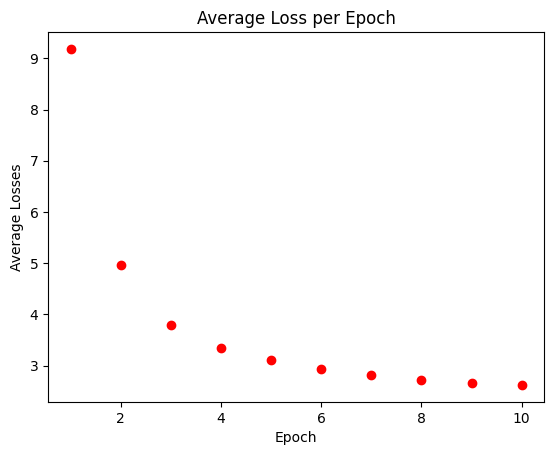

In [6]:
#train the model
bart_model, vit_model = train_multimodal_model(num_epochs=10)
    
#save the state dictionary (model weights) of the trained models for later reference
bart_model = bart_model.to("cpu") 
vit_model = vit_model.to("cpu")      
torch.save(bart_model.state_dict(), 'bart_model.pth')
torch.save(vit_model.state_dict(), 'vit_model.pth')

In [4]:
#NOTE: Please RESTART the kernel, and re-run the first two cells (from the top) prior to running the current and following cells below

import torch.nn.functional as F
from nltk.translate.meteor_score import meteor_score
from torch.nn.utils.rnn import pad_sequence
from transformers.modeling_outputs import BaseModelOutput

#load test set for sampling
test_set = load_dataset("lmms-lab/COCO-Caption", split="val[7502:10505]")
test_set = test_set.map(select_random_caption)
test_set = test_set.map(convert_to_pixel_values)
test_set.set_format(type="torch", columns=["pixel_values", "answer"])
test_loader = DataLoader(dataset=test_set, batch_size=8, shuffle=True)

Map:   1%|          | 27/3003 [00:00<00:23, 128.77 examples/s]

Pixel value dimensions: torch.Size([3, 224, 224])


Map: 100%|██████████| 3003/3003 [00:36<00:00, 81.29 examples/s] 


In [5]:
import re
import matplotlib.pyplot as plt

def normalize_caption(input_str):
    return re.sub(r"\s+", " ", input_str.strip().lower()).split()

@torch.no_grad()
def sample_multimodal_model(bartModel, vit_model):
    max_new_tokens=32
    num_beams=3
    no_repeat_ngram_size=3                            
    repetition_penalty=1.15 
    bartModel.eval()
    vit_model.eval()

    bartModel.to(device)
    vit_model.to(device)
    projector.to(device)

    sample_indices, meteor_scores = [], []

    for batch_index, batch in enumerate(test_loader):
        
        pixel_values = batch["pixel_values"].to(device)
        encoder_latent = vit_model(pixel_values=pixel_values).last_hidden_state             
        encoder_mask = torch.ones(encoder_latent.size()[:-1], dtype=torch.long, device=device)  
        encoder_output_from_bart = bartModel.model.encoder(inputs_embeds=projector(encoder_latent), attention_mask=encoder_mask)

        
        generated_token_ids = bartModel.generate(
            encoder_outputs=encoder_output_from_bart,
            attention_mask=encoder_mask,                 
            max_new_tokens=max_new_tokens,
            min_new_tokens=5,
            num_beams=num_beams,
            no_repeat_ngram_size=no_repeat_ngram_size,
            repetition_penalty=repetition_penalty,
            length_penalty=1.0,
            early_stopping=True,
            decoder_start_token_id=tokenizer.bos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )
        text_predictions = tokenizer.batch_decode(generated_token_ids, skip_special_tokens=True)

        for index, prediction in enumerate(text_predictions):
            target = batch["answer"][index]
            meteorScore = meteor_score([normalize_caption(target)], normalize_caption(prediction))
            meteor_scores.append(meteorScore)
            sample_indices.append((batch_index * 8) + index + 1)

            print(f"Expected caption: {target}")
            print(f"Generated caption: {prediction}")
            print(f"METEOR score: {meteorScore}\n")

    plt.scatter(sample_indices, meteor_scores, marker='o')
    plt.title('METEOR Score per Sample')
    plt.xlabel('Sample Index')
    plt.ylabel('METEOR Score')
    plt.show()

    print(f"Average METEOR score across all samples: {sum(meteor_scores)/len(meteor_scores)}")
    return meteor_scores


C:\Users\t_om\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


Expected caption: Giraffe and a zebra standing side by side 
Generated caption: A white white white photo of a small small small black and a large large group of a large group.
METEOR score: 0.10869565217391304

Expected caption: A street is filled with busses and cars. 
Generated caption: A white white cat sitting next to a black and a small dog.
METEOR score: 0.11764705882352941

Expected caption: A monorail train going over a pedestrian bridge
Generated caption: A small small small dog dog in a small room.
METEOR score: 0.12195121951219512

Expected caption: Commuter trains on tracks next to paved platform.
Generated caption: A group of people standing next to a white photo.
METEOR score: 0.22865853658536583

Expected caption: a large group of people is running down the interstate
Generated caption: A group of people are standing in a small room.
METEOR score: 0.37500000000000006

Expected caption: A proud young woman stands in front of a school bus painted with the words "Food is F

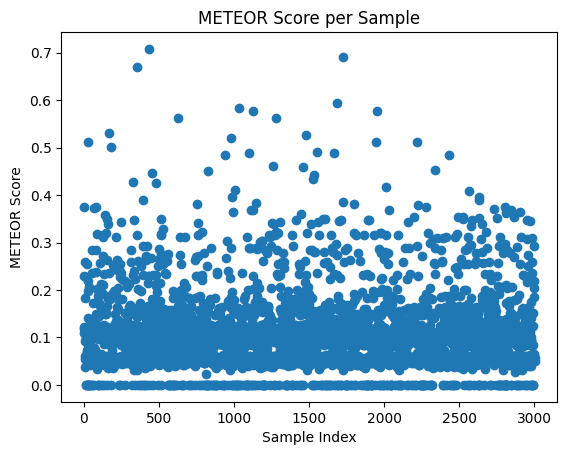

Average METEOR score across all samples: 0.11147987689038642


[0.10869565217391304,
 0.11764705882352941,
 0.12195121951219512,
 0.22865853658536583,
 0.37500000000000006,
 0.18350290697674418,
 0.037037037037037035,
 0.05494505494505494,
 0.06024096385542169,
 0.09174311926605505,
 0.11904761904761905,
 0.25813692480359146,
 0.0,
 0.22825150732127478,
 0.09708737864077671,
 0.10989010989010987,
 0.10101010101010102,
 0.0,
 0.0,
 0.06097560975609756,
 0.25555555555555554,
 0.08928571428571429,
 0.0684931506849315,
 0.05524861878453038,
 0.07407407407407407,
 0.09900990099009903,
 0.14018691588785046,
 0.19801980198019806,
 0.5113636363636364,
 0.0,
 0.09345794392523364,
 0.21802325581395351,
 0.09174311926605505,
 0.0,
 0.20618556701030927,
 0.0,
 0.0,
 0.05617977528089887,
 0.13636363636363635,
 0.0423728813559322,
 0.08547008547008547,
 0.1234567901234568,
 0.10000000000000002,
 0.053763440860215055,
 0.0,
 0.06756756756756756,
 0.05,
 0.05494505494505494,
 0.046296296296296294,
 0.05050505050505051,
 0.13761467889908252,
 0.10752688172043011,


In [ ]:
import torch

#Please feel free to change the names of the .pth model files that are loaded prior to running this cell
bartModel.load_state_dict(torch.load('bart_model.pth', map_location="cpu"))
vit_model.load_state_dict(torch.load('vit_model.pth', map_location="cpu"))

#sample the model
sample_multimodal_model(bartModel, vit_model)